# QUE 01: GMM

In [76]:
torch.cuda.empty_cache()

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.distributions as dist
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
data_path = "C:\\Users\\Gaurav Talekar\\afhq\\train"
batch_size = 8
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
dataset = ImageFolder(root=data_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=2)
print(f"Number of batches: {len(data_loader)}")
print(f"Total number of images: {len(dataset)}")


Number of batches: 1829
Total number of images: 14630


In [2]:
dataset

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: C:\Users\Gaurav Talekar\afhq\train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [3]:
data_loader

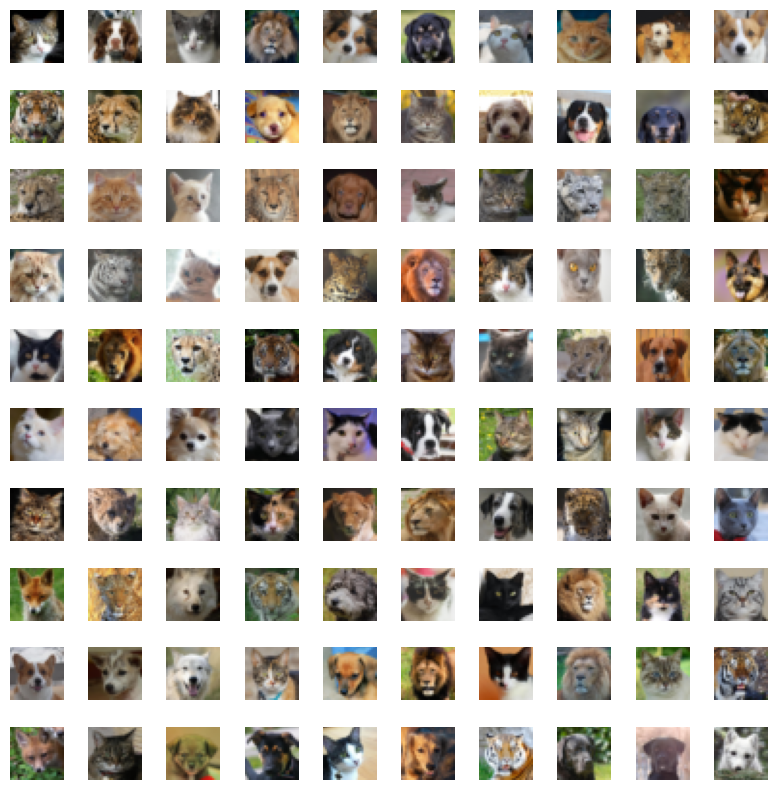

In [52]:
# # Initialize a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

# # Iterate through the DataLoader to display 100 images in the grid
for i, batch in enumerate(data_loader):
    
    image, _ = batch
    ax = axs[i // 10, i % 10]  # Get the appropriate subplot
    ax.imshow(image[0].permute(1, 2, 0).numpy())  # Assuming batch size is 1
    
    ax.axis('off')  # Turn off axis labels and ticks
    
    if i == 99: 
        
        break

plt.subplots_adjust(wspace=0.1, hspace=0.5)  # Adjust spacing between subplots
plt.show()

In [4]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

class GMM(nn.Module):
    def __init__(self, num_mixtures, num_features):
        super(GMM, self).__init__()
        self.num_mixtures = num_mixtures
        self.num_features = num_features
        self.means = nn.Parameter(torch.randn(num_mixtures, num_features))
        
        covariances = []
        for j in range(num_mixtures):
            
            cov_matrix = nn.Parameter(torch.eye(num_features))
            covariances.append(cov_matrix)
        
        
        self.covariances = nn.Parameter(torch.stack(covariances, dim=0))
        self.mixing_weights = nn.Parameter(torch.ones(num_mixtures) / num_mixtures)

   
    
    def expectation_step(self, data):
        num_samples, num_mixtures = data.shape[0], self.num_mixtures
    
        posteriors = torch.zeros(num_samples, num_mixtures)
    
        for i in range(num_samples):
            for j in range(num_mixtures):
                
                mvn = MultivariateNormal(self.means[j], covariance_matrix=self.covariances[j])
                likelihood = torch.exp(mvn.log_prob(data[i]))
            
                # Calculate the posterior probability for Gaussian j
                posteriors[i, j] = self.mixing_weights[j] * likelihood
    
            # Normalize the posteriors for each data point
            posteriors[i] /= torch.sum(posteriors[i])
    
        return posteriors
        
    def maximization_step(self, data, posteriors):
        num_samples, num_features = data.shape
        num_mixtures = posteriors.shape[1]
    
        updated_means = torch.zeros(num_mixtures, num_features)
        updated_covariances = torch.zeros(num_mixtures, num_features, num_features)
        updated_mixing_weights = torch.zeros(num_mixtures)
    
        for j in range(num_mixtures):
            # Update mixing weight
            updated_mixing_weights[j] = torch.mean(posteriors[:, j])
        
            # Update mean
            updated_means[j] = torch.sum(data * posteriors[:, j].view(-1, 1), dim=0) / torch.sum(posteriors[:, j])
        
            # Update covariance
            diff = data - updated_means[j]
            cov = torch.mm((posteriors[:, j].view(-1, 1) * diff).t(), diff)
            updated_covariances[j] = cov / torch.sum(posteriors[:, j])
    
        return updated_means, updated_covariances, updated_mixing_weights

    def log_likelihood(self, data):
        num_samples, num_features = data.shape
        num_mixtures = self.means.shape[0]

        likelihoods = torch.zeros(num_samples)

        for i in range(num_samples):
            log_likelihood = 0
            for j in range(num_mixtures):
                mvn = MultivariateNormal(self.means[j], covariance_matrix=self.covariances[j])
                log_likelihood += torch.log(self.mixing_weights[j]) + mvn.log_prob(data[i])

            likelihoods[i] = log_likelihood

        return torch.sum(torch.logsumexp(likelihoods, dim=0))


In [81]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
num_mixtures = 3  
num_features = 28 * 28 * 3
gmm = GMM(num_mixtures, num_features)


def train_gmm(gmm, data_loader, optimizer, num_iterations):
    likelihoods = []
    gmm = gmm.to("cuda")
    for iteration in range(num_iterations):
        for batch in data_loader:
            data = batch[0].view(batch[0].size(0), -1)  # Flatten images
            data = data.to("cuda")

            # E-step
            posteriors = gmm.expectation_step(data)

            # M-step
            gmm.maximization_step(data, posteriors)

            # Calculate and log the log-likelihood
            log_likelihood = gmm.log_likelihood(data)
            likelihoods.append(log_likelihood.item())
        print(f"Iteration {iteration + 1}/{num_iterations}, Log Likelihood: {log_likelihood.item()}")

    return likelihoods

In [82]:
def plot_likelihood_curve(likelihoods):
    plt.plot(likelihoods)
    plt.xlabel("Iteration")
    plt.ylabel("Log Likelihood")
    plt.title("Log Likelihood Curve")
    plt.show()

In [83]:
image_size=28
num_iterations = 100
def generate_images(gmm, num_samples):
    with torch.no_grad():
        samples = gmm.sample(num_samples)
        samples = samples.view(num_samples, 3, image_size, image_size)
        vutils.save_image(samples, "generated_images.png", nrow=10, normalize=True)


In [84]:

def compute_nmi(gmm, data_loader):
    true_labels = []
    predicted_labels = []

    for batch in data_loader:
        data, labels = batch[0].view(batch[0].size(0), -1), batch[1]
        data = data.to("cuda")

        # E-step for posterior inference
        posteriors = gmm.expectation_step(data)

        # Calculate predicted labels based on posteriors
        predicted = torch.argmax(posteriors, dim=1)

        true_labels.extend(labels.cuda().numpy())
        predicted_labels.extend(predicted.cuda().numpy())

    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return nmi


In [ ]:
num_mixtures = 3  # You can adjust this number as needed
num_features = 28 * 28 * 3
gmm = GMM(num_mixtures, num_features)

# Define your optimizer
optimizer = torch.optim.Adam(gmm.parameters(), lr=0.01)

# Training loop
num_iterations = 50  # Adjust the number of iterations as needed
for iteration in range(num_iterations):
    for batch in data_loader:
        data = batch[0].view(batch_size, num_features)
        # E-step: Calculate responsibilities
        posteriors = gmm.expectation_step(data)
    
        # M-step: Update parameters
        gmm.maximization_step(data, posteriors)
        log_likelihood = gmm.log_likelihood(data)
    
    # Calculate and print the log likelihood
    #log_likelihood = gmm.log_likelihood(data)
    print(f"Iteration {iteration + 1}/{num_iterations}, Log Likelihood: {log_likelihood.item()}")

In [ ]:
# Main Code

from tqdm import tqdm
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_mixtures_list = [3, 5, 7]  # Experiment with different numbers of mixtures
    num_iterations = 5  # Number of EM iterations

    for num_mixtures in num_mixtures_list:
        gmm = GMM(num_mixtures, image_size * image_size * 3)
        
        # Move the entire model to the GPU
        gmm = gmm.to(device)
        
        optimizer = torch.optim.Adam(gmm.parameters(), lr=0.01)
        # Use tqdm to create a progress bar for iterations
        for iteration in tqdm(range(num_iterations), desc=f"Mixtures: {num_mixtures}"):
            likelihoods = train_gmm(gmm, dataloader, optimizer, num_iterations) 
            plot_likelihood_curve(likelihoods)

        generate_images(gmm, num_samples=100)

        nmi = compute_nmi(gmm, dataloader)
        print(f"Number of Mixtures: {num_mixtures}, NMI: {nmi}")
        
    

# QUE 02:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = ImageFolder(root="C:\\Users\\Gaurav Talekar\\train", transform=transform)
val_dataset = ImageFolder(root="C:\\Users\\Gaurav Talekar\\val", transform=transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)



In [6]:
BATCH_SIZE = 128
IMAGE_SIZE = 28
LATENT_DIM = 64
NUM_EPOCHS = 50
NUM_CLASSES = 3

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.SELU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.SELU(),
            nn.BatchNorm2d(64),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.SELU(),
            nn.Linear(512, LATENT_DIM * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 512),
            nn.SELU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.SELU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.SELU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = x[:, :LATENT_DIM], x[:, LATENT_DIM:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [12]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Likelihood term (MSE)
    MSE = nn.MSELoss(reduction='sum')
    mse_loss = MSE(recon_x, x)

    # KL divergence term
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combined loss
    loss = mse_loss +  beta*kld_loss  

    return loss, mse_loss, kld_loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [14]:
beta = 1  # Adjust beta as needed
vae.train()
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss, mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Total Loss: {loss.item() / len(data)}, MSE Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}")

Epoch [1/50] Total Loss: 68.75404759457237, MSE Loss: 54.3405183490954, KL Loss: 14.41352763928865
Epoch [2/50] Total Loss: 65.07309441817434, MSE Loss: 49.84205386513158, KL Loss: 15.231040553042764
Epoch [3/50] Total Loss: 66.91690866570724, MSE Loss: 50.007173237047695, KL Loss: 16.90973703484786
Epoch [4/50] Total Loss: 59.24421772203947, MSE Loss: 43.231252569901315, KL Loss: 16.0129683645148
Epoch [5/50] Total Loss: 58.64515445106908, MSE Loss: 42.5341796875, KL Loss: 16.11097476356908
Epoch [6/50] Total Loss: 60.970979389391445, MSE Loss: 44.77857730263158, KL Loss: 16.19240208675987
Epoch [7/50] Total Loss: 57.0038420024671, MSE Loss: 40.82613332648026, KL Loss: 16.177711888363486
Epoch [8/50] Total Loss: 61.346872430098685, MSE Loss: 45.51474802117599, KL Loss: 15.83212601511102
Epoch [9/50] Total Loss: 66.16696006373355, MSE Loss: 49.694772820723685, KL Loss: 16.47218724300987
Epoch [10/50] Total Loss: 67.26055586965461, MSE Loss: 50.89135420949835, KL Loss: 16.36920326634457

In [15]:
from torchvision.utils import save_image

vae.eval()
with torch.no_grad():
    for i in range(10):
        z = torch.randn(128, LATENT_DIM).to(device)
        generated_images = vae.decode(z)
        save_image(generated_images.view(128, 3, 28, 28),  # Adjust the view operation
                   f"Generated_samples_{i}.png", nrow=10, normalize=True)







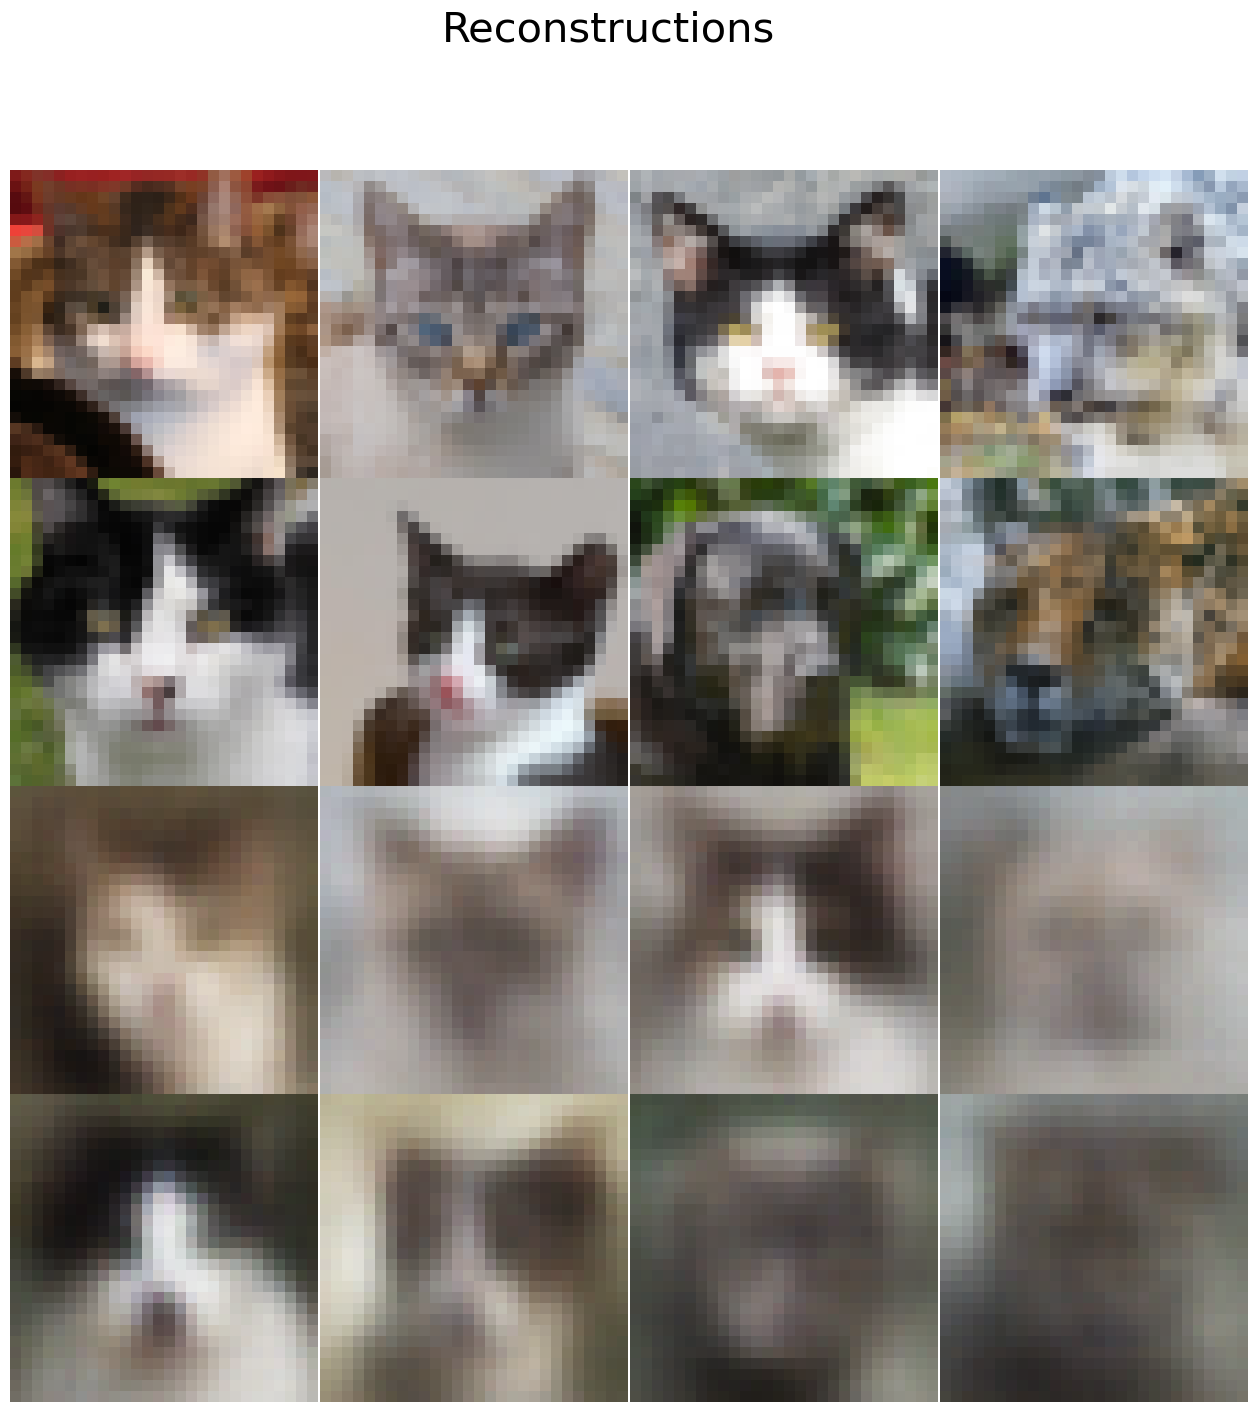

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(images, title, legend_fontsize=20):
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i, ax in enumerate(axes.flat):
        image = images[0][i].permute(1, 2, 0).cpu().detach().numpy()
        ax.imshow(np.clip(image, 0, 1))  # Ensure values are in the [0, 1] range
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title, fontsize=legend_fontsize)  # Set the fontsize for the legend
    plt.show()

# Load and display reconstructions
reconstruction_images = [torch.cat([data[:8].to(device), recon_batch[:8]]).cpu()]
plot_grid(reconstruction_images, "Reconstructions", legend_fontsize=30)  # Adjust the legend_fontsize as needed


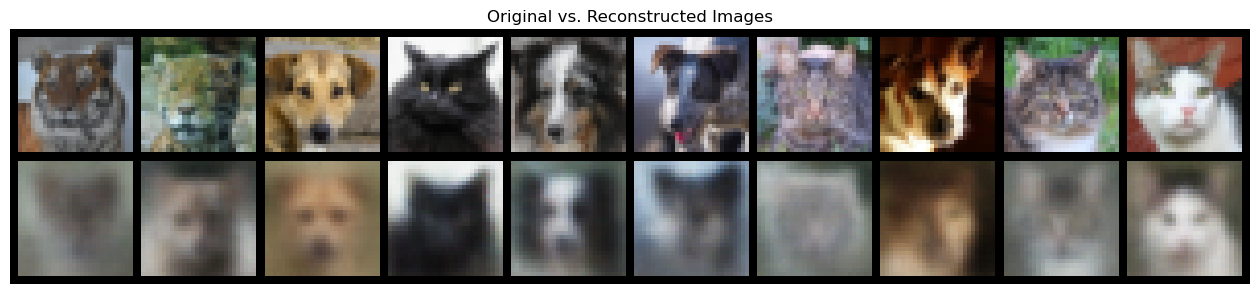

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to plot original and reconstructed images side by side
def plot_original_reconstructed(vae,val_dataloader, device):
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_iter = iter(val_dataloader)
        data, _ = next(data_iter)
        data = data.to(device)
        
        # Reconstruct the data
        recon_batch, _, _ = vae(data)
        
        # Create a grid of original and reconstructed images
        combined_images = torch.cat([data[:10], recon_batch[:10]])
        
        # Plot the grid of images
        plt.figure(figsize=(16, 10))
        plt.axis("off")
        plt.title("Original vs. Reconstructed Images")
        plt.imshow(vutils.make_grid(combined_images, nrow=10, normalize=True).cpu().numpy().transpose(1, 2, 0))
        plt.show()

# Call the function to plot original and reconstructed images
plot_original_reconstructed(vae, val_dataloader, device)


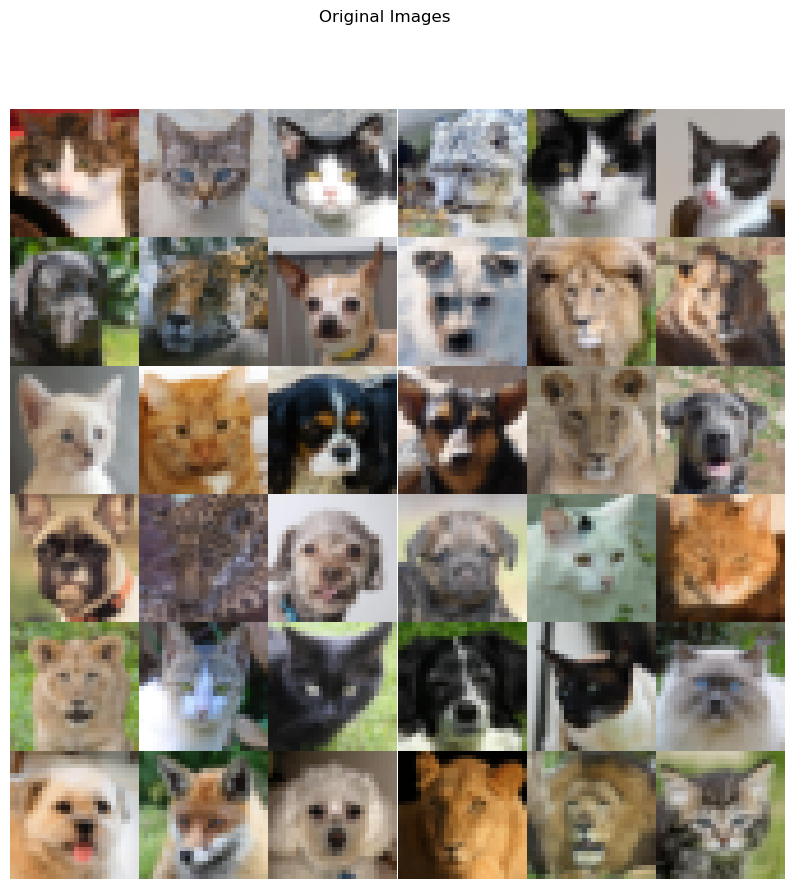

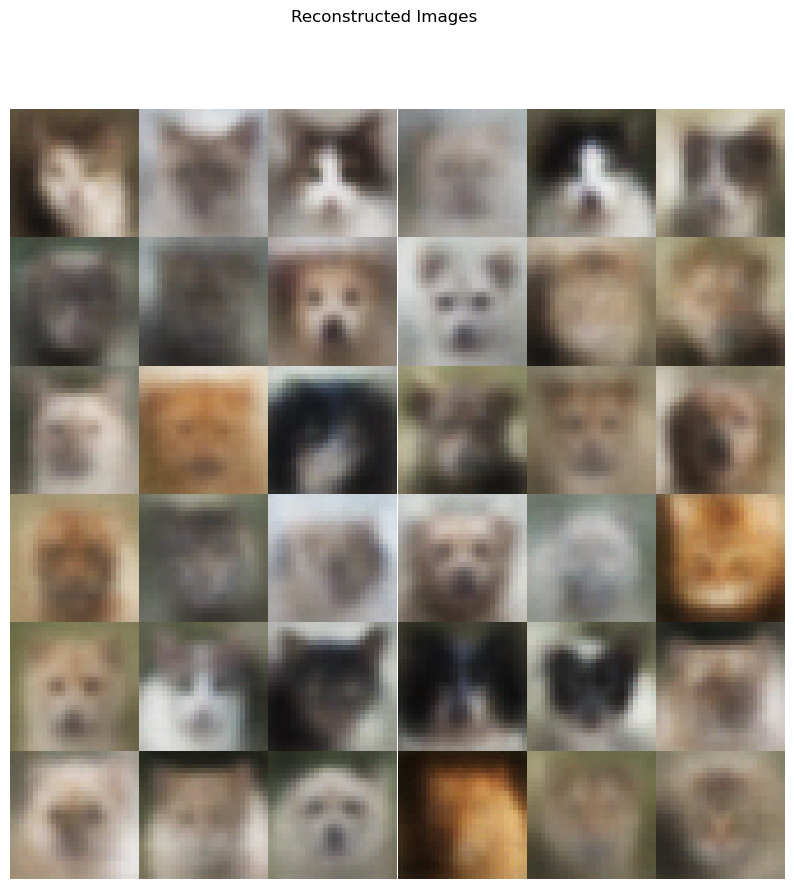

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(images, title):
    num_images = images.size(0)
    grid_size = int(np.sqrt(num_images))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    
    if grid_size == 1:  # Handle the case when grid size is 1x1
        axes = np.array([[axes]])
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            index = i * grid_size + j
            if index < num_images:
                image = images[index].detach().cpu().permute(1, 2, 0).numpy()
                ax.imshow(np.clip(image, 0, 1))
                ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    plt.show()

# Load and display the first 100 original images
plot_grid(data[:100], "Original Images")

# Load and display the first 100 reconstructed images
plot_grid(recon_batch[:100], "Reconstructed Images")



Epoch [1/50] Likelihood Loss: 24.066544382195723, KL Loss: 0.07327361483322947, Combined Loss: 24.13981869346217
Epoch [2/50] Likelihood Loss: 24.16194554379112, KL Loss: 0.0794543843520315, Combined Loss: 24.24140046772204
Epoch [3/50] Likelihood Loss: 21.854203073601973, KL Loss: 0.09104478986639726, Combined Loss: 21.945248252467106
Epoch [4/50] Likelihood Loss: 19.352992007606908, KL Loss: 0.09786165388006914, Combined Loss: 19.45085384971217
Epoch [5/50] Likelihood Loss: 17.7571732370477, KL Loss: 0.10192820272947613, Combined Loss: 17.8591019479852
Epoch [6/50] Likelihood Loss: 20.06194425884046, KL Loss: 0.10755548979106702, Combined Loss: 20.169499447471217
Epoch [7/50] Likelihood Loss: 16.468774092824834, KL Loss: 0.11049472658257735, Combined Loss: 16.579268606085527
Epoch [8/50] Likelihood Loss: 16.200625770970394, KL Loss: 0.11396814647473787, Combined Loss: 16.31459446957237
Epoch [9/50] Likelihood Loss: 16.209776225842926, KL Loss: 0.11625833260385614, Combined Loss: 16.3

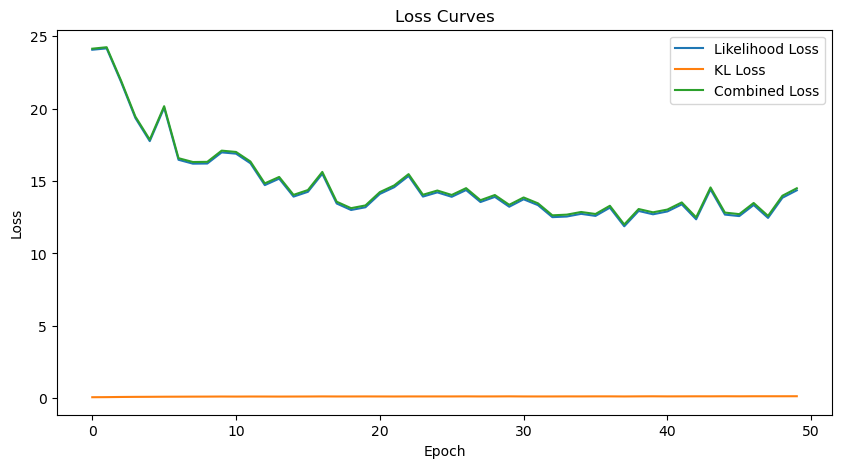

In [19]:
import matplotlib.pyplot as plt

# Initialize empty lists to store losses
likelihood_losses = []
kl_losses = []
combined_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        
        # Calculate likelihood loss
        mse_loss = nn.MSELoss(reduction='sum')(recon_batch, data)
        
        # Calculate KL divergence loss
        prior = torch.distributions.Normal(0, 1)
        posterior = torch.distributions.Normal(mu, logvar.exp().sqrt())
        kld_loss = torch.mean(torch.distributions.kl.kl_divergence(posterior, prior))
        
        # Combined loss
        loss = mse_loss + kld_loss * beta
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Store losses for this epoch
    likelihood_losses.append(mse_loss.item() / len(data))
    kl_losses.append(kld_loss.item() / len(data))
    combined_losses.append(loss.item() / len(data))

    # Print and save losses at the end of each epoch
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Likelihood Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}, Combined Loss: {loss.item() / len(data)}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(likelihood_losses, label='Likelihood Loss')
plt.plot(kl_losses, label='KL Loss')
plt.plot(combined_losses, label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.grid(True)
plt.show()


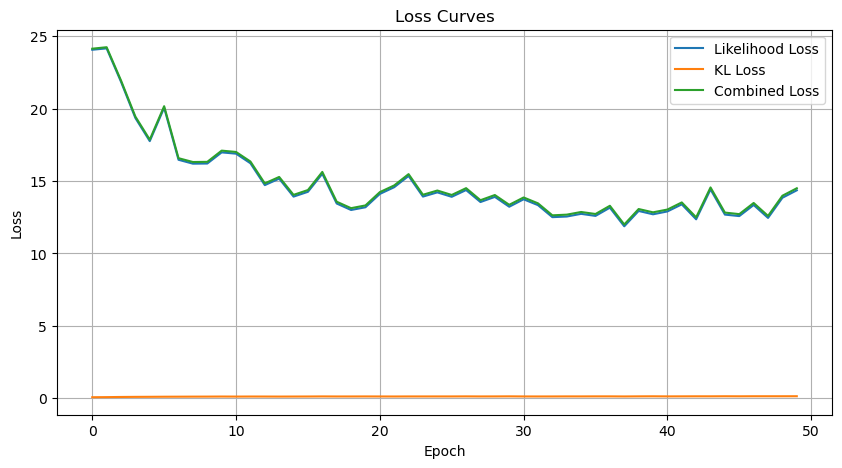

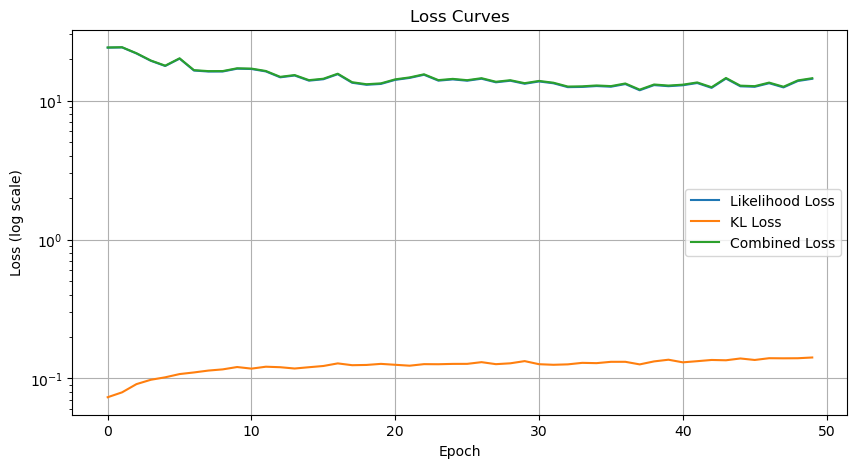

In [21]:
plt.figure(figsize=(10, 5))
plt.semilogy(np.arange(len(likelihood_losses)), likelihood_losses, label='Likelihood Loss')
plt.semilogy(np.arange(len(kl_losses)), kl_losses, label='KL Loss')
plt.semilogy(np.arange(len(combined_losses)), combined_losses, label='Combined Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Loss Curves')
plt.grid(True)  


# CNN Classifier

In [37]:
torch.manual_seed(42)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image values to range [-1, 1]
])

# Load the dataset
train_dataset = ImageFolder("C:\\Users\\Gaurav Talekar\\train", transform=transform)
val_dataset = ImageFolder("C:\\Users\\Gaurav Talekar\\val", transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [38]:
# Define the custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 output classes

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN().to(device)

In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Calculate validation loss and accuracy
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.6274, Val Loss: 0.3695, Val Accuracy: 86.47%
Epoch 2/10, Train Loss: 0.2997, Val Loss: 0.2802, Val Accuracy: 89.80%
Epoch 3/10, Train Loss: 0.2144, Val Loss: 0.1951, Val Accuracy: 92.60%
Epoch 4/10, Train Loss: 0.1700, Val Loss: 0.1661, Val Accuracy: 93.87%
Epoch 5/10, Train Loss: 0.1386, Val Loss: 0.1669, Val Accuracy: 93.67%
Epoch 6/10, Train Loss: 0.1165, Val Loss: 0.1567, Val Accuracy: 94.27%
Epoch 7/10, Train Loss: 0.0942, Val Loss: 0.1797, Val Accuracy: 93.00%
Epoch 8/10, Train Loss: 0.0837, Val Loss: 0.1479, Val Accuracy: 94.47%
Epoch 9/10, Train Loss: 0.0658, Val Loss: 0.1523, Val Accuracy: 94.93%
Epoch 10/10, Train Loss: 0.0540, Val Loss: 0.1552, Val Accuracy: 95.07%


# Posterior Inference

In [41]:
def get_latent_vector(vae, dataloader, device):
    vae.eval()  
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for images, labels_batch in dataloader:
            images = images.to(device)
            _, mu, log_var = vae(images)  
            z = vae.reparameterize(mu, log_var)  
            latent_vectors.append(z.cpu().numpy())
            labels.append(labels_batch.numpy())
    
    # Concatenate the latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels





In [42]:
train_latent_vectors, train_labels = get_latent_vector(vae, train_dataloader, device)
val_latent_vectors, val_labels = get_latent_vector(vae, val_dataloader, device)

In [43]:
val_latent_vectors.shape

(1500, 64)

In [49]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

In [52]:
input_dim = train_latent_vectors.shape[1]
hidden_dim = 128
output_dim = 3

In [53]:
classifier = MLPClassifier(input_dim, hidden_dim, output_dim)
classifier.to(device)


criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [54]:

num_classes = len(np.unique(train_dataset.targets))   
output_dim = 3 
mlp_cls = MLPClassifier(LATENT_DIM, num_classes,output_dim)
mlp_cls.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_cls.parameters(), lr=0.001)
train_losses = []
val_losses = []
val_accuracies = []
patience = 5
best_val_loss = float('inf')
counter = 0




In [56]:
train_dataloader_length = len(train_labels)
for epoch in range(num_epochs):
    mlp_cls.train()
    total_train_loss = 0.0
    train = torch.utils.data.TensorDataset(torch.tensor(train_latent_vectors, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
    train_load = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    for inputs, labels in train_load:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = mlp_cls(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    average_train_loss = total_train_loss / len(train_load)

    
    mlp_cls.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        val = torch.utils.data.TensorDataset(torch.tensor(val_latent_vectors, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
        val_load = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

        for inputs, labels in val_load:
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = mlp_cls(inputs)
            val_loss = criterion(val_outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(val_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    average_val_loss = total_val_loss / len(val_load)
    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered.")
        break
final_val_accuracy = val_accuracy

print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.9463, Val Loss: 0.8832, Val Accuracy: 62.47%
Epoch 2/10, Train Loss: 0.8640, Val Loss: 0.8436, Val Accuracy: 66.87%
Epoch 3/10, Train Loss: 0.8308, Val Loss: 0.8130, Val Accuracy: 70.93%
Epoch 4/10, Train Loss: 0.7937, Val Loss: 0.7756, Val Accuracy: 73.27%
Epoch 5/10, Train Loss: 0.7343, Val Loss: 0.7083, Val Accuracy: 75.93%
Epoch 6/10, Train Loss: 0.6678, Val Loss: 0.6525, Val Accuracy: 76.93%
Epoch 7/10, Train Loss: 0.6164, Val Loss: 0.6223, Val Accuracy: 76.47%
Epoch 8/10, Train Loss: 0.5875, Val Loss: 0.6012, Val Accuracy: 77.07%
Epoch 9/10, Train Loss: 0.5712, Val Loss: 0.5921, Val Accuracy: 77.60%
Epoch 10/10, Train Loss: 0.5610, Val Loss: 0.5860, Val Accuracy: 77.67%
Final Validation Accuracy: 77.67%


# QUE 03: Beta VAE

Epoch [1/10] Beta: 0.1, Total Loss: 38.24528423108553, MSE Loss: 28.58678556743421, KL Loss: 96.58499948601974
Epoch [2/10] Beta: 0.1, Total Loss: 34.04025750411184, MSE Loss: 24.248997738486842, KL Loss: 97.91261050575658
Epoch [3/10] Beta: 0.1, Total Loss: 31.98509457236842, MSE Loss: 22.48622693513569, KL Loss: 94.98866031044408
Epoch [4/10] Beta: 0.1, Total Loss: 29.39994410464638, MSE Loss: 20.33994493986431, KL Loss: 90.60000128495066
Epoch [5/10] Beta: 0.1, Total Loss: 32.29308760793585, MSE Loss: 22.627560264185856, KL Loss: 96.65526058799342
Epoch [6/10] Beta: 0.1, Total Loss: 29.035708778782894, MSE Loss: 19.5139449270148, KL Loss: 95.2176449424342
Epoch [7/10] Beta: 0.1, Total Loss: 31.95157984683388, MSE Loss: 22.33311060855263, KL Loss: 96.1846988075658
Epoch [8/10] Beta: 0.1, Total Loss: 30.834861353824014, MSE Loss: 21.36122532894737, KL Loss: 94.73635382401316
Epoch [9/10] Beta: 0.1, Total Loss: 27.821652061060856, MSE Loss: 18.654789974814967, KL Loss: 91.6686112253289

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002CD7747FAF0>
Traceback (most recent call last):
  File "C:\Users\Gaurav Talekar\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\Gaurav Talekar\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


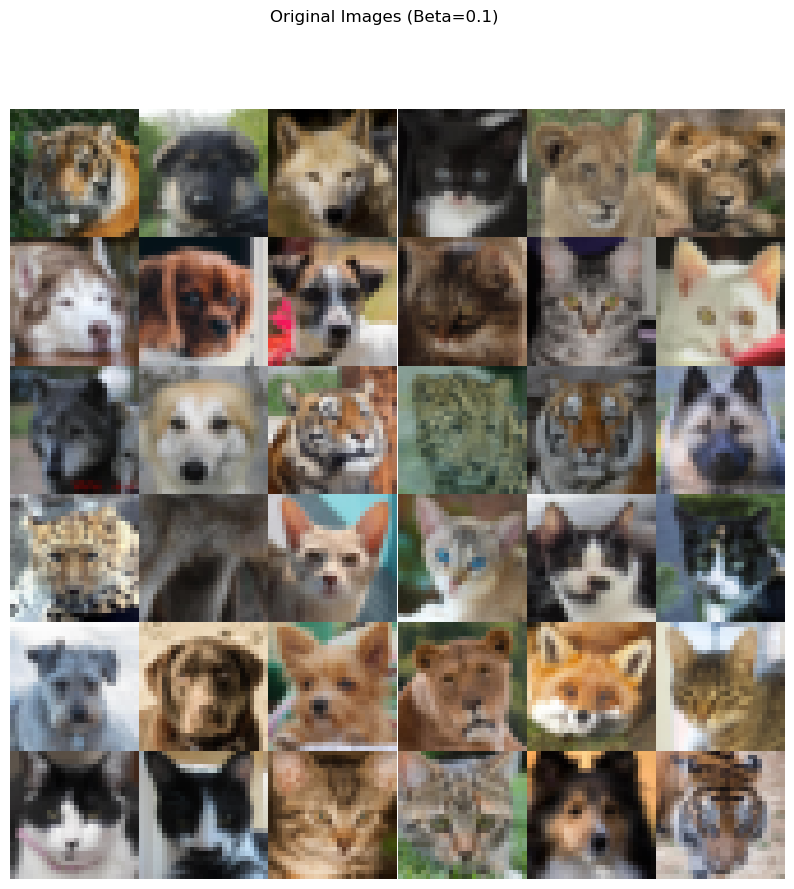

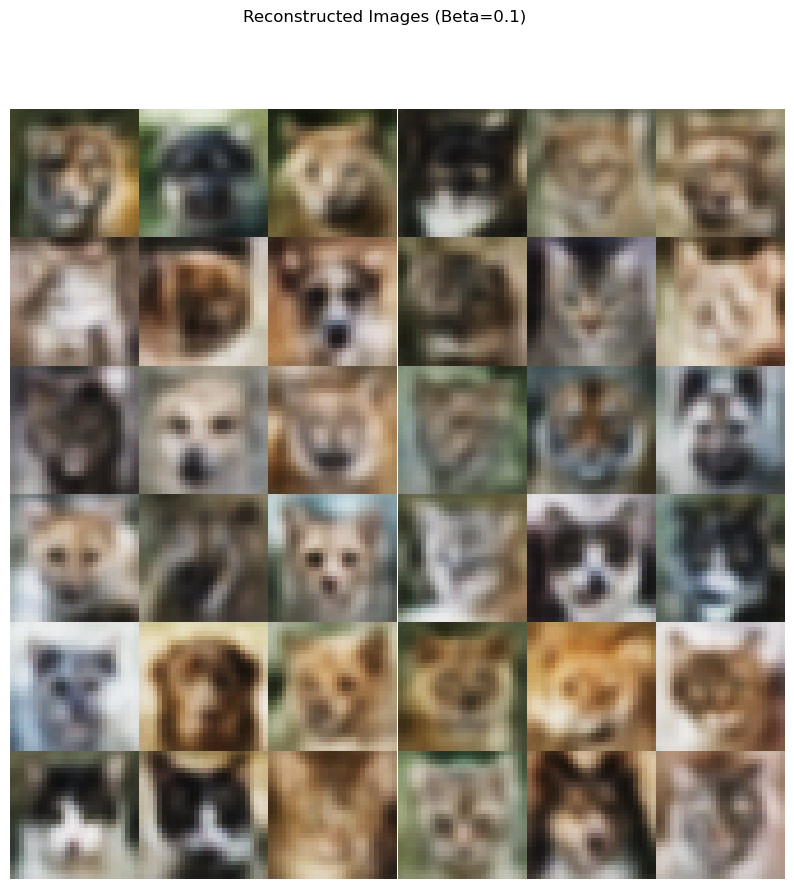

Epoch [1/10] Beta: 0.5, Total Loss: 62.36536929481908, MSE Loss: 47.68323396381579, KL Loss: 29.364267449629935
Epoch [2/10] Beta: 0.5, Total Loss: 56.114591899671055, MSE Loss: 41.853098016036185, KL Loss: 28.522987767269736
Epoch [3/10] Beta: 0.5, Total Loss: 51.949636358963815, MSE Loss: 37.78015457956415, KL Loss: 28.338966771175986
Epoch [4/10] Beta: 0.5, Total Loss: 47.73476048519737, MSE Loss: 33.1009521484375, KL Loss: 29.267616673519736
Epoch [5/10] Beta: 0.5, Total Loss: 48.12111302425987, MSE Loss: 34.01787045127467, KL Loss: 28.20648193359375
Epoch [6/10] Beta: 0.5, Total Loss: 53.46968158922697, MSE Loss: 39.15281596936678, KL Loss: 28.633731239720394
Epoch [7/10] Beta: 0.5, Total Loss: 54.99510433799342, MSE Loss: 39.35675048828125, KL Loss: 31.27671412417763
Epoch [8/10] Beta: 0.5, Total Loss: 46.86273193359375, MSE Loss: 31.940359015213815, KL Loss: 29.84474583675987
Epoch [9/10] Beta: 0.5, Total Loss: 50.309541401110195, MSE Loss: 35.4656404194079, KL Loss: 29.68780196

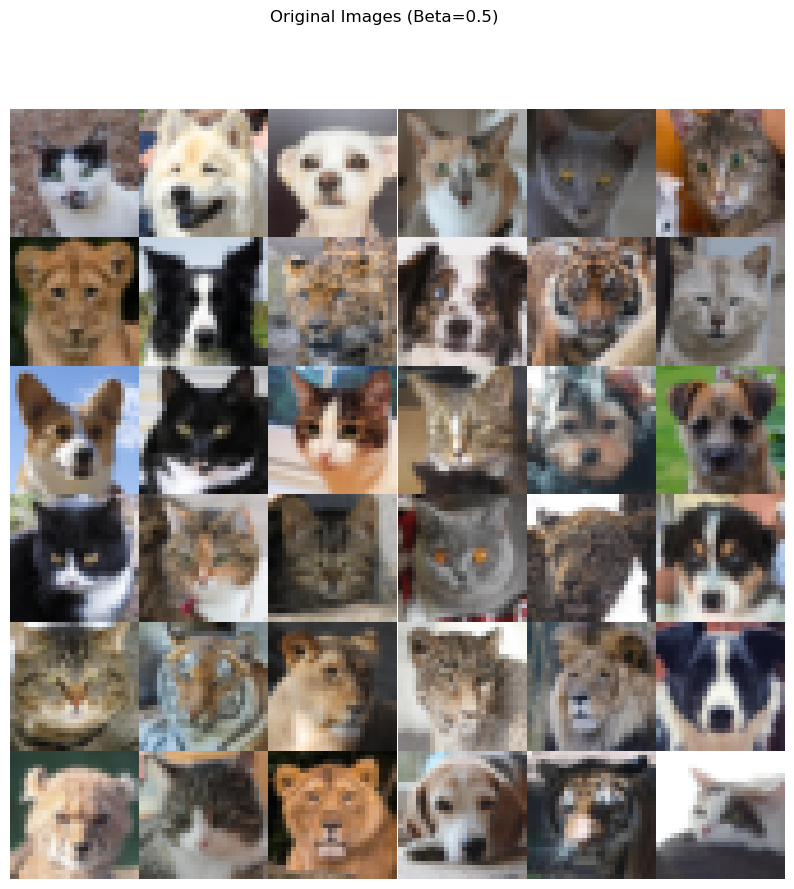

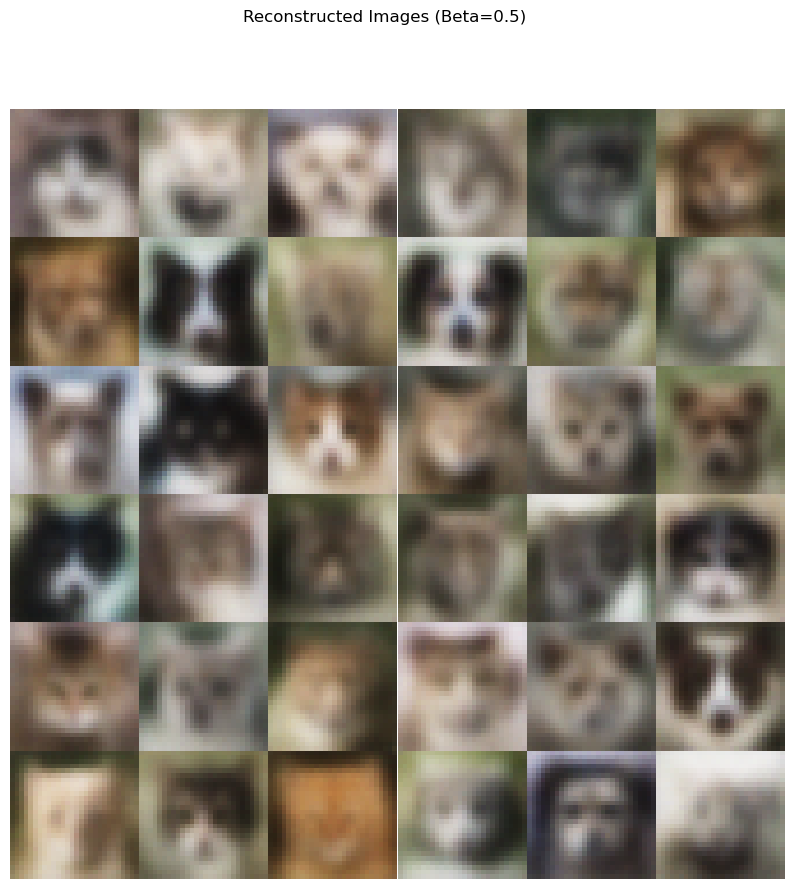

Epoch [1/10] Beta: 1.5, Total Loss: 82.27009020353618, MSE Loss: 62.9192537006579, KL Loss: 12.900557668585526
Epoch [2/10] Beta: 1.5, Total Loss: 71.32656378495066, MSE Loss: 54.53078099300987, KL Loss: 11.197188527960526
Epoch [3/10] Beta: 1.5, Total Loss: 73.73954050164474, MSE Loss: 55.429289165296055, KL Loss: 12.20683368883635
Epoch [4/10] Beta: 1.5, Total Loss: 66.07000411184211, MSE Loss: 49.89686986019737, KL Loss: 10.782091642680921
Epoch [5/10] Beta: 1.5, Total Loss: 70.66695363898026, MSE Loss: 54.142822265625, KL Loss: 11.016089991519326
Epoch [6/10] Beta: 1.5, Total Loss: 69.7760074013158, MSE Loss: 52.43361302425987, KL Loss: 11.56159892835115
Epoch [7/10] Beta: 1.5, Total Loss: 66.59274773848684, MSE Loss: 47.68147679379112, KL Loss: 12.607513427734375
Epoch [8/10] Beta: 1.5, Total Loss: 65.71678402549342, MSE Loss: 48.83485171669408, KL Loss: 11.254621003803454
Epoch [9/10] Beta: 1.5, Total Loss: 64.82256116365132, MSE Loss: 48.36533717105263, KL Loss: 10.9714829294305

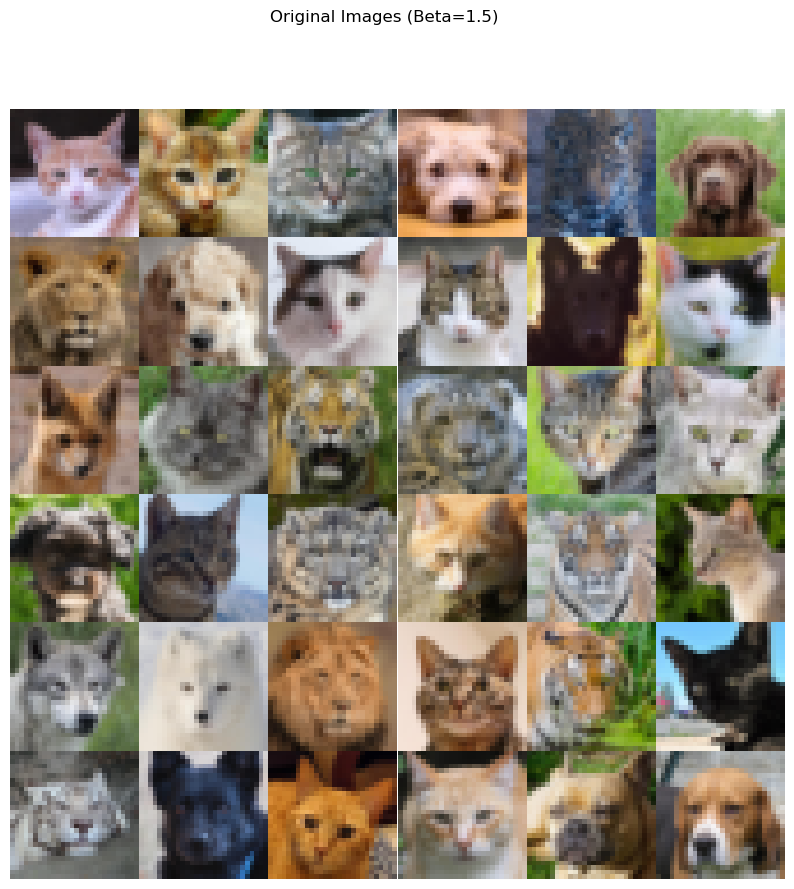

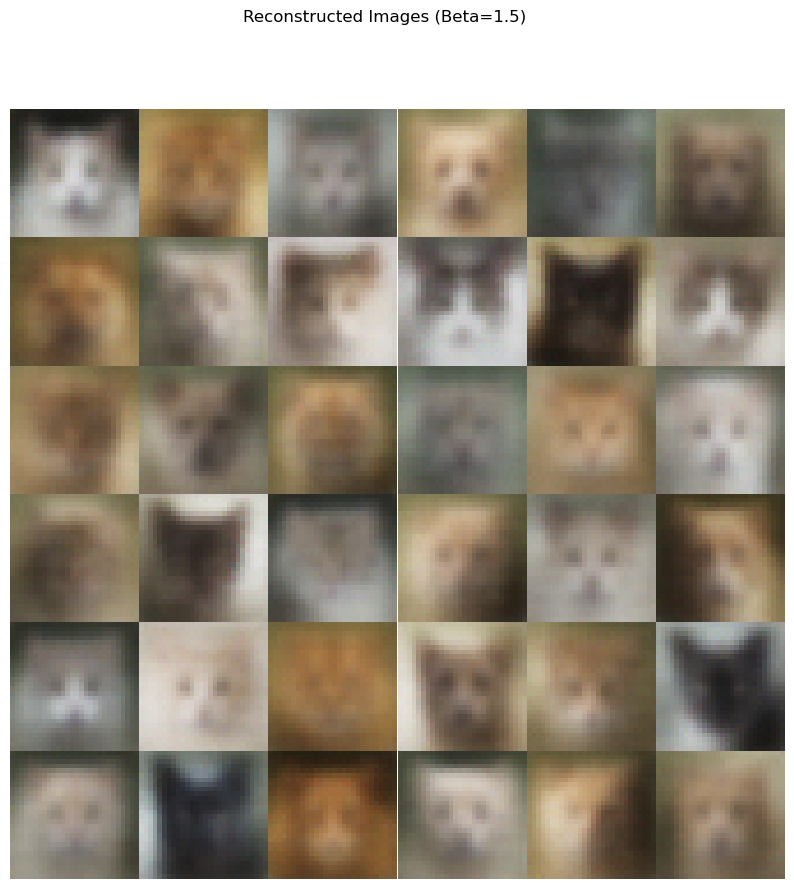

Epoch [1/10] Beta: 2.0, Total Loss: 84.00237715871711, MSE Loss: 65.04985608552632, KL Loss: 9.476260536595396
Epoch [2/10] Beta: 2.0, Total Loss: 78.75055895353618, MSE Loss: 60.48844829358553, KL Loss: 9.131055329975329
Epoch [3/10] Beta: 2.0, Total Loss: 73.31688168174342, MSE Loss: 54.39973530016447, KL Loss: 9.458573190789474
Epoch [4/10] Beta: 2.0, Total Loss: 76.52862870065789, MSE Loss: 58.728361430921055, KL Loss: 8.90013283177426
Epoch [5/10] Beta: 2.0, Total Loss: 78.06294973273026, MSE Loss: 58.2510408100329, KL Loss: 9.905956067537007
Epoch [6/10] Beta: 2.0, Total Loss: 77.80232319078948, MSE Loss: 58.25931589226974, KL Loss: 9.77150525544819
Epoch [7/10] Beta: 2.0, Total Loss: 80.45027883429276, MSE Loss: 61.3943513569079, KL Loss: 9.527962935598273
Epoch [8/10] Beta: 2.0, Total Loss: 75.61060855263158, MSE Loss: 57.12595086348684, KL Loss: 9.24233045076069
Epoch [9/10] Beta: 2.0, Total Loss: 72.80742444490132, MSE Loss: 54.60463353207237, KL Loss: 9.101396259508634
Epoch

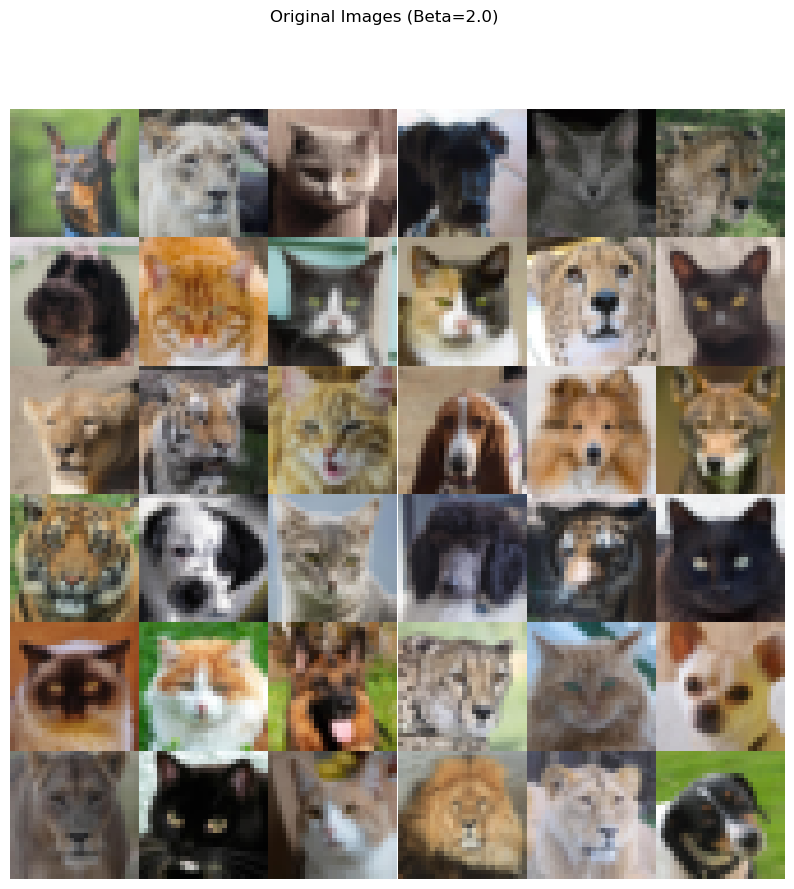

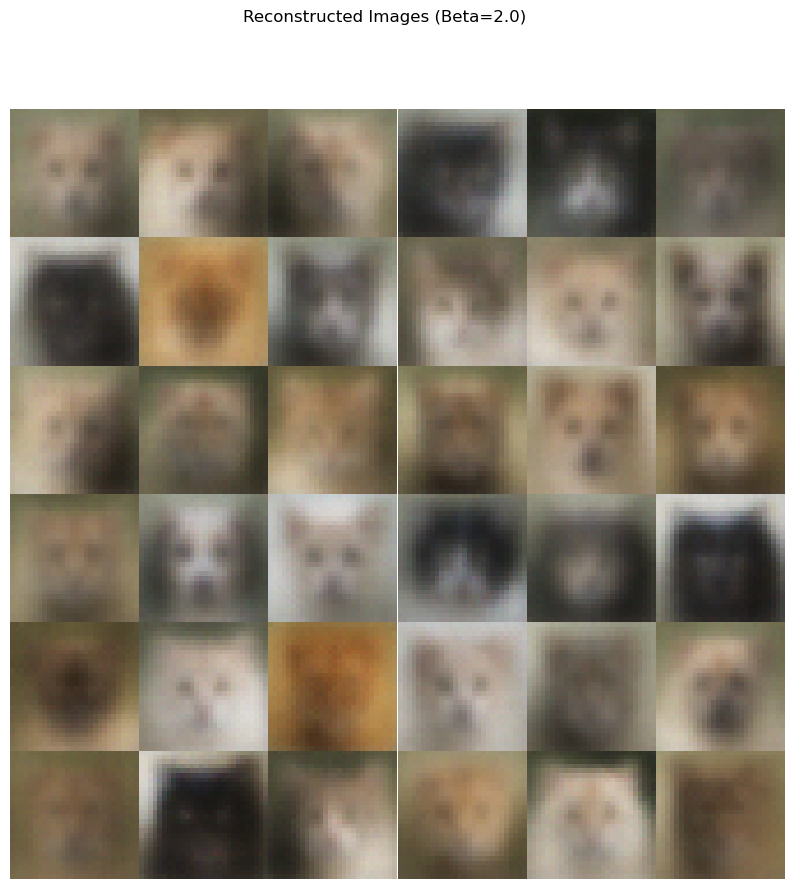

In [67]:

beta_values = [0.1, 0.5, 1.5, 2.0]
NUM_EPOCHS = 10
LATENT_DIM = 128

# Define your loss function outside of the training loop
def loss_function(recon_x, x, mu, logvar, beta):
    # Likelihood term (MSE)
    MSE = nn.MSELoss(reduction='sum')
    mse_loss = MSE(recon_x, x)

    # KL divergence term
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combined loss
    loss = mse_loss +  beta * kld_loss  

    return loss, mse_loss, kld_loss

# Function to train and save a VAE for a specific beta value
def train_and_save_vae(beta,train_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE().to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    
    vae.train()
    for epoch in range(NUM_EPOCHS):
        for batch_idx, (data, _) in enumerate(train_dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss, mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] Beta: {beta}, Total Loss: {loss.item() / len(data)}, MSE Loss: {mse_loss.item() / len(data)}, KL Loss: {kld_loss.item() / len(data)}")
    torch.save(vae.state_dict(), f"vae_model_beta{beta}.pt")
    vae.eval()
    with torch.no_grad():
        for i in range(10):
            z = torch.randn(128, LATENT_DIM).to(device)
            generated_images = vae.decode(z)
            save_image(generated_images.view(128, 3, 28, 28), f"Generated_samples_{i}_beta{beta}.png", nrow=10, normalize=True)

    # Load and display the first 100 original images
    plot_grid(data[:100], f"Original Images (Beta={beta})")

    # Load and display the first 100 reconstructed images
    plot_grid(recon_batch[:100], f"Reconstructed Images (Beta={beta})")

# Loop through different beta values and train/save a VAE for each
for beta in beta_values:
    train_and_save_vae(beta, train_dataloader)


In [68]:
model_filename = f"vae_model_beta{0.1}.pt"  # Replace with the actual filename
vae = VAE()  # Create an instance of the VAE
vae.load_state_dict(torch.load(model_filename))
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SELU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SELU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=512, bias=True)
    (7): SELU()
    (8): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): SELU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): SELU()
    (7): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

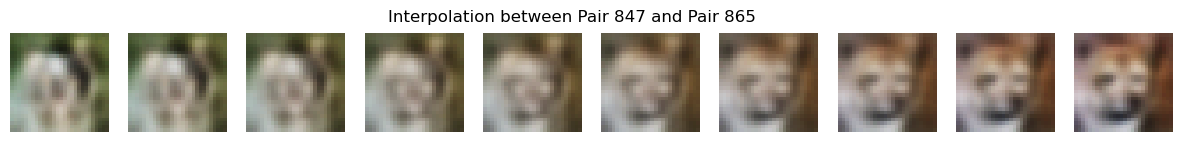

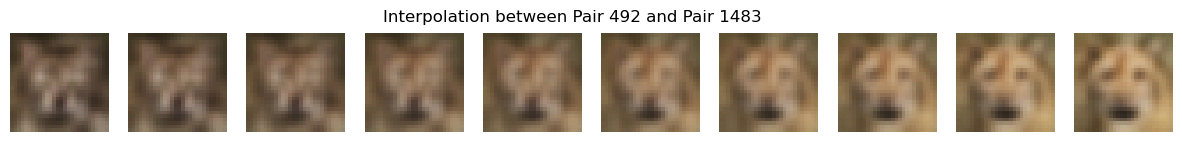

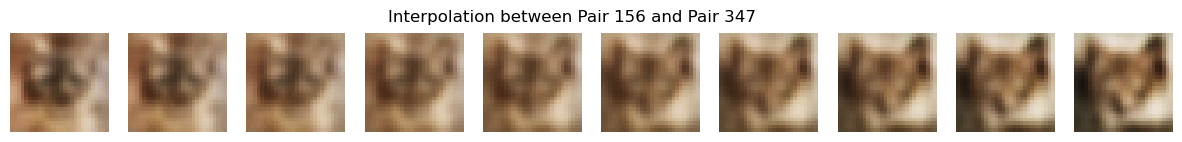

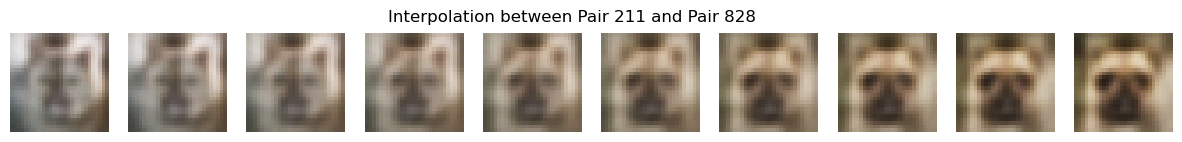

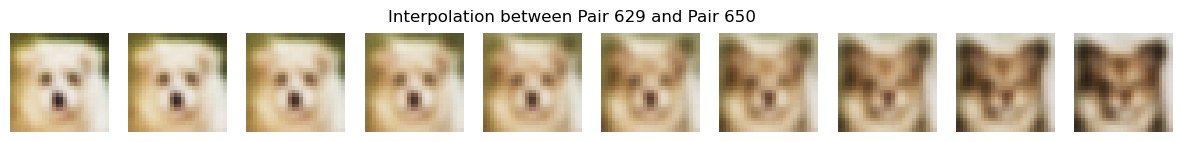

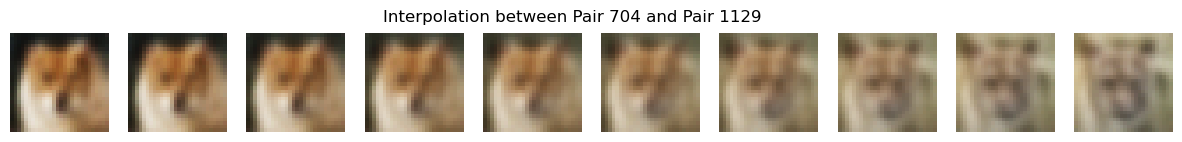

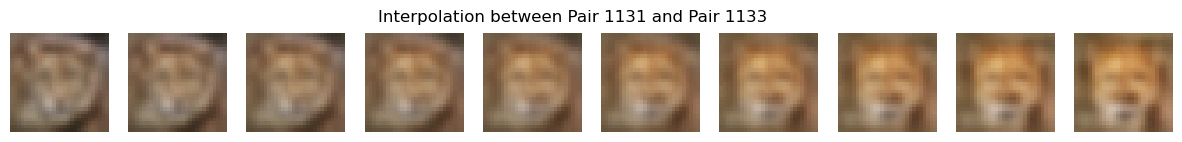

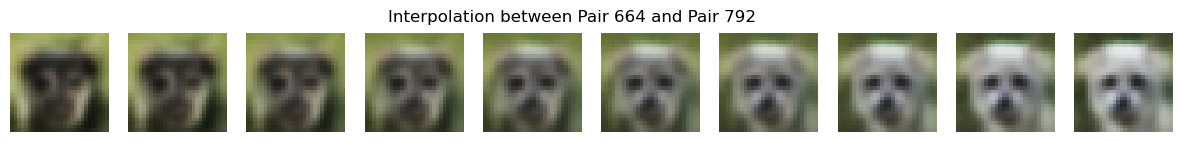

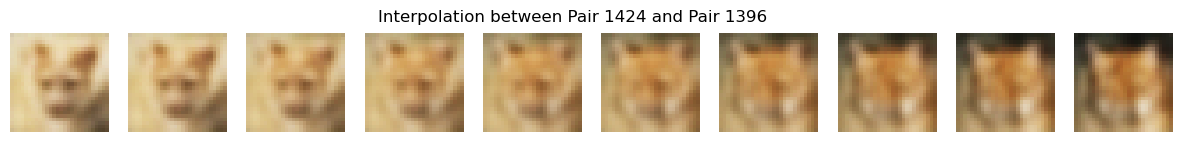

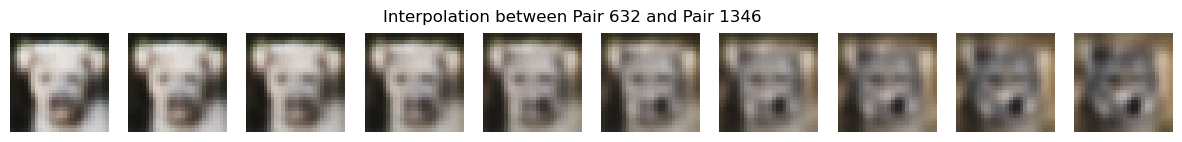

In [79]:
num_interpolations = 10
num_pairs = 10
latent_dim = 128
pair_indices = torch.randint(0, len(val_dataset), (num_pairs, 2))

for pair_index in pair_indices:
    image1 = val_dataset[pair_index[0]][0]  # Assuming your dataset returns (image, label), get the image
    image2 = val_dataset[pair_index[1]][0]

    with torch.no_grad():
        _, mu1, log_var1 = vae(image1.unsqueeze(0))
        _, mu2, log_var2 = vae(image2.unsqueeze(0))
        latent1 = vae.reparameterize(mu1, log_var1)
        latent2 = vae.reparameterize(mu2, log_var2)

    
    interpolated_latents = torch.stack([(1 - alpha) * latent1 + alpha * latent2 for alpha in torch.linspace(0, 1, num_interpolations)])

    with torch.no_grad():
        interpolated_images = vae.decoder(interpolated_latents.view(-1, latent_dim))  # Reshape interpolated_latents

    
    plt.figure(figsize=(15, 1.5))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_interpolations, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())  # Convert to numpy and permute the dimensions
        plt.axis('off')

    plt.suptitle(f'Interpolation between Pair {pair_index[0]} and Pair {pair_index[1]}')
    plt.show()




# Que 04: Vanilla Autoencoder